### subjective/neutral of sentences analyzer
1. import the json file consists of speechs include "China"
2. use model to calculate the probability of subjective/neutral assign to sentences
3. restore the result to the independent json files
4. calculate the average, median and standard deviation of scores by president and year
5. calculate the average scores by year
6. visualize the result

In [47]:
#pip install transformers
#pip install torch torchvision torchaudio

In [3]:
import torch

In [4]:
from transformers import pipeline

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [6]:
import json
import os
import numpy as np
import pandas as pd

In [7]:
tokenizer = AutoTokenizer.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")

c:\anaconda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
def process_sentences(json_file_path, max_length=512):
    processed_sentences = []
    
    # read json file
    with open(json_file_path, 'r') as file:
        sentences_data = json.load(file)
    
    # iterate each sentence
    for entry in sentences_data:
        sentence = entry['sentence']
        
        # tokenize and truncate
        tokens = tokenizer(sentence, truncation=True, max_length=512, return_tensors="pt", padding=True)
        
        # convert to text
        truncated_sentence = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
        
        # save processed sentence
        processed_sentences.append(truncated_sentence)
    
    return processed_sentences

In [9]:
classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True,
)

c:\anaconda\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [60]:
classify(input_text3)

[[{'label': 'SUBJECTIVE', 'score': 0.9008364677429199},
  {'label': 'NEUTRAL', 'score': 0.09916352480649948}]]

In [10]:
with open('./speech_json/37_nixon_speech.json', 'r') as file:
    nixon_speech = json.load(file)

with open('./speech_json/38_ford_speech.json', 'r') as file:
    ford_speech = json.load(file)

with open('./speech_json/39_carter_speech.json', 'r') as file:
    carter_speech = json.load(file)

with open('./speech_json/40_reagan_speech.json', 'r') as file:
    reagan_speech = json.load(file)

with open('./speech_json/41_herbertbush_speech.json', 'r') as file:
    herbertbush_speech = json.load(file)

with open('./speech_json/42_clinton_speech.json', 'r') as file:
    clinton_speech = json.load(file)

with open('./speech_json/43_walkerbush_speech.json', 'r') as file:
    walkerbush_speech = json.load(file)

with open('./speech_json/44_obama_speech.json', 'r') as file:
    obama_speech = json.load(file)

with open('./speech_json/45_trump_speech.json', 'r') as file:
    trump_speech = json.load(file)

with open('./speech_json/46_biden_speech.json', 'r') as file:
    biden_speech = json.load(file)

with open('./speech_json/47_vicepresident_biden_speech.json', 'r') as file:
    vicepresident_biden_speech = json.load(file)



In [11]:
def calculate_scores(speech_file, output_file):
    results = []

    for entry in speech_file:
        sentence = entry['sentence']
        date = entry['date']
        tokens = tokenizer(sentence, truncation=True, max_length=512, return_tensors="pt", padding=True)
        truncated_sentence = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
        result = classify(truncated_sentence)
        subjective_score, neutral_score = result[0][0]['score'], result[0][1]['score']

        # Collect sentences with their scores and dates
        results.append({
            "date": date,
            "subjective_score": subjective_score,
            "neutral_score": neutral_score,
            "sentence": sentence
        })

    # Save results to a JSON file
    with open(output_file, 'w') as outfile:
        json.dump(results, outfile, indent=4)

    return results

In [18]:
# nixon_results = calculate_scores(nixon_speech, 'nixon_scores.json')
# ford_results = calculate_scores(ford_speech, 'ford_scores.json')
# carter_results = calculate_scores(carter_speech, 'carter_scores.json')
# reagan_results = calculate_scores(reagan_speech, 'reagan_scores.json')
# herbertbush_results = calculate_scores(herbertbush_speech, 'herbertbush_scores.json')
# clinton_results = calculate_scores(clinton_speech, 'clinton_scores.json')
# walkerbush_results = calculate_scores(walkerbush_speech, 'walkerbush_scores.json')
# obama_results = calculate_scores(obama_speech, 'obama_scores.json')
# trump_results = calculate_scores(trump_speech, 'trump_scores.json')
# biden_results = calculate_scores(biden_speech, 'biden_scores.json')
# vicepresident_biden_results = calculate_scores(vicepresident_biden_speech, 'vicepresident_biden_scores.json')


In [12]:
with open('./subjective_scores_json/nixon_scores.json', 'r') as file:
    nixon_scores = json.load(file)

with open('./subjective_scores_json/ford_scores.json', 'r') as file:
    ford_scores = json.load(file)

with open('./subjective_scores_json/carter_scores.json', 'r') as file:
    carter_scores = json.load(file)

with open('./subjective_scores_json/reagan_scores.json', 'r') as file:
    reagan_scores = json.load(file)

with open('./subjective_scores_json/herbertbush_scores.json', 'r') as file:
    herbertbush_scores = json.load(file)

with open('./subjective_scores_json/clinton_scores.json', 'r') as file:
    clinton_scores = json.load(file)

with open('./subjective_scores_json/walkerbush_scores.json', 'r') as file:
    walkerbush_scores = json.load(file)

with open('./subjective_scores_json/obama_scores.json', 'r') as file:
    obama_scores = json.load(file)

with open('./subjective_scores_json/trump_scores.json', 'r') as file:
    trump_scores = json.load(file)

with open('./subjective_scores_json/biden_scores.json', 'r') as file:
    biden_scores = json.load(file)

with open('./subjective_scores_json/vicepresident_biden_scores.json', 'r') as file:
    vicepresident_biden_scores = json.load(file)


In [24]:
def statistics_calculator(scores, presidentname):

    subjective_scores = [score['subjective_score'] for score in scores]
    neutral_scores = [score['neutral_score'] for score in scores if score['neutral_score'] < 0.9]
    
    if not subjective_scores:
        return None, None, None
    
    average_subjective_score = round(np.mean(subjective_scores), 3)
    median_subjective_score = round(np.median(subjective_scores), 3)
    std_dev_subjective_score = round(np.std(subjective_scores), 3)
    average_neutral_score = round(np.mean(neutral_scores), 3)
    median_neutral_score = round(np.median(neutral_scores), 3)
    std_dev_neutral_score = round(np.std(neutral_scores), 3) 

    print(f"president_name: {presidentname}")
    print(f"average_subjective_score: {average_subjective_score:.3f}")
    print(f"median_subjective_score: {median_subjective_score:.3f}")
    print(f"std_dev_subjective_score: {std_dev_subjective_score:.3f}")
    print(f"average_neutral_score: {average_neutral_score:.3f}")
    print(f"median_neutral_score: {median_neutral_score:.3f}")
    print(f"std_dev_neutral_score: {std_dev_neutral_score:.3f}")

    results = {
        "president_name": presidentname,
        "average_subjective_score": average_subjective_score,
        "median_subjective_score": median_subjective_score,
        "std_dev_subjective_score": std_dev_subjective_score,
        "average_neutral_score": average_neutral_score,
        "median_neutral_score": median_neutral_score,
        "std_dev_neutral_score": std_dev_neutral_score
    }

    # Save results to a JSON file
    with open('scores_statistics.json', 'a') as outfile:
        json.dump(results, outfile, indent=4)
    
    return average_subjective_score, median_subjective_score, std_dev_subjective_score, average_neutral_score, median_neutral_score, std_dev_neutral_score



In [25]:
# nixon_statistics = statistics_calculator(nixon_scores, "nixon")
# ford_statistics = statistics_calculator(ford_scores, "ford")
# carter_statistics = statistics_calculator(carter_scores, "carter")
# reagan_statistics = statistics_calculator(reagan_scores, "reagan")
# herbertbush_statistics = statistics_calculator(herbertbush_scores, "herbertbush")
# clinton_statistics = statistics_calculator(clinton_scores, "clinton")
# walkerbush_statistics = statistics_calculator(walkerbush_scores, "walkerbush")
# obama_statistics = statistics_calculator(obama_scores, "obama")
# trump_statistics = statistics_calculator(trump_scores, "trump")
# biden_statistics = statistics_calculator(biden_scores, "biden")
# vicepresident_biden_statistics = statistics_calculator(vicepresident_biden_scores, "vicepresident_biden")


president_name: nixon
average_subjective_score: 0.638
median_subjective_score: 0.655
std_dev_subjective_score: 0.200
average_neutral_score: 0.354
median_neutral_score: 0.343
std_dev_neutral_score: 0.191
president_name: ford
average_subjective_score: 0.642
median_subjective_score: 0.688
std_dev_subjective_score: 0.235
average_neutral_score: 0.353
median_neutral_score: 0.304
std_dev_neutral_score: 0.230
president_name: carter
average_subjective_score: 0.614
median_subjective_score: 0.668
std_dev_subjective_score: 0.250
average_neutral_score: 0.368
median_neutral_score: 0.323
std_dev_neutral_score: 0.232
president_name: reagan
average_subjective_score: 0.615
median_subjective_score: 0.653
std_dev_subjective_score: 0.265
average_neutral_score: 0.361
median_neutral_score: 0.327
std_dev_neutral_score: 0.243
president_name: herbertbush
average_subjective_score: 0.580
median_subjective_score: 0.602
std_dev_subjective_score: 0.236
average_neutral_score: 0.408
median_neutral_score: 0.385
std_dev

In [47]:
import matplotlib.pyplot as plt

def visualize_scores(scores_statistics):
    presidents = [entry['president_name'] for entry in scores_statistics]
    average_subjective_scores = [entry['average_subjective_score'] for entry in scores_statistics]
    median_subjective_scores = [entry['median_subjective_score'] for entry in scores_statistics]
    average_neutral_scores = [entry['average_neutral_score'] for entry in scores_statistics]
    median_neutral_scores = [entry['median_neutral_score'] for entry in scores_statistics]

    plt.figure(figsize=(14, 7))

    # Plot average and median subjective scores
    plt.subplot(1, 2, 1)
    plt.plot(presidents, average_subjective_scores, marker='o', label='Average Subjective Score')
    plt.plot(presidents, median_subjective_scores, marker='o', label='Median Subjective Score')
    plt.xlabel('President')
    plt.ylabel('Score')
    plt.title('Subjective Scores')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot average and median neutral scores
    plt.subplot(1, 2, 2)
    plt.plot(presidents, average_neutral_scores, marker='o', label='Average Neutral Score')
    plt.plot(presidents, median_neutral_scores, marker='o', label='Median Neutral Score')
    plt.xlabel('President')
    plt.ylabel('Score')
    plt.title('Neutral Scores')
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [48]:
with open('./scores_statistics.json', 'r') as file:
    scores_statistics = json.load(file)

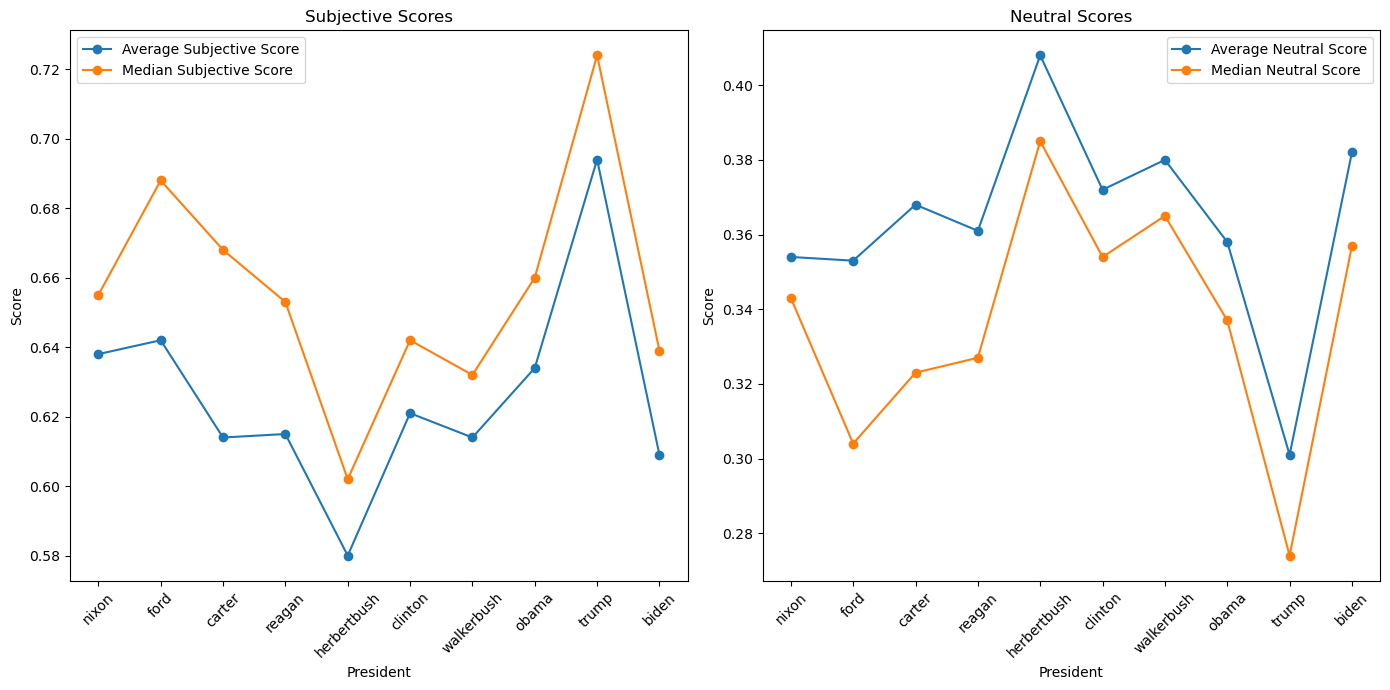

In [49]:
visualize_scores(scores_statistics)

In [28]:
def calculate_average_scores(speech_file):
    scores = []
    total_subjective_score = 0
    total_neutral_score = 0
    count = 0
    subjective_sentences = []
    neutral_sentences = []

    for entry in speech_file:
        sentence = entry['sentence']
        tokens = tokenizer(sentence, truncation=True, max_length=512, return_tensors="pt", padding=True)
        truncated_sentence = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
        result = classify(truncated_sentence)
        subjective_score, neutral_score = result[0][0]['score'], result[0][1]['score']
        total_subjective_score += subjective_score
        total_neutral_score += neutral_score
        count += 1

        # Collect sentences with their scores
        subjective_sentences.append((sentence, subjective_score))
        neutral_sentences.append((sentence, neutral_score))

    average_subjective_score = total_subjective_score / count
    average_neutral_score = total_neutral_score / count

    print(f"Average Subjective Score: {average_subjective_score}")
    print(f"Average Neutral Score: {average_neutral_score}")
    scores.append(average_subjective_score)
    scores.append(average_neutral_score)

    # Sort and print top 10 subjective and neutral sentences
    subjective_sentences.sort(key=lambda x: x[1], reverse=True)
    neutral_sentences.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 Subjective Sentences:")
    for sentence, score in subjective_sentences[:10]:
        print(f"{score:.4f}: {sentence}")

    print("\nTop 10 Neutral Sentences:")
    for sentence, score in neutral_sentences[:10]:
        print(f"{score:.4f}: {sentence}")

    return scores


In [45]:
nixon_scores = calculate_average_scores(nixon_scores)

Average Subjective Score: 0.6384612598364953
Average Neutral Score: 0.36153873993067415

Top 10 Subjective Sentences:
0.9960: Regrettably, only three holders of such passports were permitted entry to China
0.9945: "The meeting between the leaders of China and the United States is to seek the normalization of relations between the two countries and also to exchange views on questions of concern to the two sides." This announcement could have the most profound significance for future generations
0.9919: And the Prime Minister naturally said one city must be Shanghai, the biggest city in China
0.9900: Some rather naive observers have assumed that because I was going to Mainland China, that the differences between Mainland China and its 800 million people and its Government and that of the United States--that those differences would evaporate
0.9898: That visit does not mean that the differences between the Governments of the People's Republic of China and that of the United States are goi

In [64]:
ford_scores = calculate_average_scores(ford_speech)

Average Subjective Score: 0.6419007938230437
Average Neutral Score: 0.35809920947446205

Top 10 Subjective Sentences:
0.9938: China is a major country and a great country
0.9839: The People's Republic of China announced today the passing away of Chairman Mao Tse-tung
0.9787: Our agricultural abundance helped open the door to 800 million people on the mainland of China
0.9771: Well, in 1972 when we reopened the doors between China and the United States, a Shanghai communiqué was issued which called for the gradual movement of better relations, broader relations, deeper relations, aiming at some point to normalization of relations
0.9768: The process of normalizing relations with the People's Republic of China, in which Ambassador Gates will play a very vital role, is now well underway
0.9736: George Bush was our representative in the People's Republic of China and in that capacity did extremely well
0.9707: This visit gives us all a great farewell boost on our way to the People's Republ

In [74]:
carter_scores = calculate_average_scores(carter_speech)

Average Subjective Score: 0.6137709823428451
Average Neutral Score: 0.38622901762308864

Top 10 Subjective Sentences:
0.9970: We had a good and useful trip to China
0.9956: The Congress has acted wisely in passing legislation amending the Foreign Assistance Act to authorize the Overseas Private Investment Corporation (OPIC) to operate in the People's Republic of China
0.9940: And now a multibillion dollar expansion program in their own trade and also a multibillion dollar expansion program in investments, commercial investments in China, could very easily be financed through normal or private business loans because of China's very excellent credit rating
0.9935: The agreement resumes scheduled air service between our country and mainland China after a gap of 31 years
0.9907: There's a fairly good crop of grain in China and some other areas of the world
0.9900: I know there's a great feeling of gratitude in China and the United States for this new, wonderful relationship
0.9878: The nor

In [65]:
reagan_scores = calculate_average_scores(reagan_speech)

Average Subjective Score: 0.6146424750768584
Average Neutral Score: 0.38535752293097725

Top 10 Subjective Sentences:
0.9976: This excellent program brings young people from Canada, China, France, Germany, Italy, Japan, Mexico, and the United Kingdom to EPCOT
0.9963: China is now embarked on an exciting experiment designed to modernize the economy and quadruple the value of its national economic output by the year 2000
0.9928: Both the United States and China have stood together in condemning the evil and unlawful invasion of Afghanistan
0.9912: In FY-1983, nearly 10,000 immigrant visas were issued by our Foreign Service posts in China
0.9911: Reform in China is now widespread and dramatic
0.9910: In 1981 a bright, young American student, John Zeidman, came here to study China and to seek new friends
0.9892: Well, America and China are both great nations
0.9880: Horowitz was named consul general at the American consulate in Sydney, Australia, in 1981, and in 1984 to present, deputy chi

In [66]:
herbertbush_scores = calculate_average_scores(herbertbush_speech)

Average Subjective Score: 0.5798382258281269
Average Neutral Score: 0.42016177417269385

Top 10 Subjective Sentences:
0.9963: Charles Pei Wang, President of the China Institute in America, an outstanding new addition
0.9925: And China does have the proper policy
0.9915: And for this we must credit the reforms China embarked upon 10 years ago under Chairman Deng Xiaoping's farsighted leadership
0.9904: In 1989 U.S.-China trade amounted to $18 billion, and China was our 10th largest trading partner worldwide
0.9794: MFN is based on emigration, and emigration has continued from China at respectable levels
0.9764: Maintaining flexibility in administering our productive student and scholar exchange program with China is important
0.9749: We will keep them under review for future adjustments to respond to further positive developments in China
0.9733: But we've passed the day on the U.S.-China relationship where anyone talks about "playing a card." That was a term that was highly offensive t

In [80]:
clinton_scores = calculate_average_scores(clinton_speech)

Average Subjective Score: 0.6210600175086957
Average Neutral Score: 0.3789399818752506

Top 10 Subjective Sentences:
0.9962: Fifteen other airplanes followed on a daring one-way trip to Tokyo and on to China
0.9953: Under the wise, compassionate leadership of Eleanor Roosevelt, half a century ago 18 delegates from China to Lebanon, Chile to Ukraine forged the first international agreement on the rights of humankind
0.9949: The Administration notes that large portions and important portions of the President's interview with Chinese news organizations were carried and prominently featured in broadcast and reporting in China and that's good
0.9948: One, the United States Trade Representative's Office negotiated this tremendous agreement with China
0.9947: Many courageous proponents of change in China agree
0.9945: The first is the best Secretary of Education this country ever had, Dick Riley, who is in China tonight
0.9939: Third -- and a shameless attempt to get on ESPN's Sports Center o

In [81]:
walkerbush_scores = calculate_average_scores(walkerbush_speech)

Average Subjective Score: 0.6137421405494247
Average Neutral Score: 0.38625786029825787

Top 10 Subjective Sentences:
0.9947: China has undergone an amazing transformation in its economy
0.9939: And so China is a fascinating country that is significant in its size
0.9935: China is a great country
0.9935: China is a great country
0.9932: Australia, fortunately, has got a surplus with China
0.9932: And finally, I want to pay tribute to Sandy Randt, who has done a fabulous job as our Ambassador to China
0.9916: We helped bring China and Taiwan into the World Trade Organization, and that's good
0.9907: And so my job is to say to China, "Open up your markets." My job is to say to Europe, "Open up your markets." And we're making progress
0.9907: That's why China is very much involved in the process now, which is helpful
0.9903: China is a great emerging nation

Top 10 Neutral Sentences:
0.9754: Awards include the Fielding Internship Award and the Luce Scholarship to the People's Republic of 

In [82]:
obama_scores = calculate_average_scores(obama_speech)

Average Subjective Score: 0.634195702759308
Average Neutral Score: 0.3658042977734973

Top 10 Subjective Sentences:
0.9962: The former Governor of Washington State, current Commerce Secretary, soon-to-be Ambassador to China--that's all one person--Gary Locke is here with his beautiful wife
0.9960: And as President Obama rightly said just now, sound China-U.S
0.9959: China of course now is the second-largest economy in the world
0.9953: China appropriately called back a shipment of arms to Zimbabwe, and the U.S
0.9952: Unfortunately, Russia and China vetoed a resolution that would have passed through the Security Council
0.9942: Christie Vilsack
 His Excellency Ding Xuexiang, Permanent Deputy Director, General Office of Central Committee of the Communist Party of China
 Mr
0.9939: The new visa extension that begins today will bring more Chinese tourists to the United States and more American tourists to see the magnificent sights of China
0.9936: It's the spirit that brought a young wom

In [79]:
trump_scores = calculate_average_scores(trump_speech)

Average Subjective Score: 0.693941963181561
Average Neutral Score: 0.3060580367922221

Top 10 Subjective Sentences:
0.9968: That's going to be an easy one.
 Since China joined -- and it's another beauty -- the World Trade Organization in 2001, the United States has lost many more than 60,000 factories
0.9965: As he rightly pointed before leaving China, it was a week that changed the world
0.9953: Biden supported every globalist sellout of Ohio workers for over a half a century, including NAFTA, China's entry into the World Trade Organization, the disaster known as TPP, and the— how about the Paris Climate Accord? [ ] That's another beauty
0.9952: Unfortunately, it does come in from China
0.9952: For the last 30 years, China—and in all fairness, and other countries
0.9950: I said to Sonny Perdue, Secretary of Agriculture, great guy, "How much have we been targeted for our farmers by China?" He said, "Sir, two years ago, $12 billion and last year, 16
0.9947: [ ] And weeks ago, we also si

In [78]:
biden_scores = calculate_average_scores(biden_speech)

Average Subjective Score: 0.6091680643858312
Average Neutral Score: 0.39083193566408403

Top 10 Subjective Sentences:
0.9956: Trump suggested that Mark Milley, who is a hell of a soldier, Chairman of the Joint Chiefs, was—Mark Milley should, quote, "face death" because he contacted China following January 6 to reassure them that the United States was still stable
0.9941: According to my excellent colleagues from Reuters, the administration is, you know, consulting with allies regarding further sanctions against China if China decides to deliver weapons to Russia
0.9914: Because Chinese steel companies produce a lot more steel than China needs, it ends up dumping the extra steel into the global markets at unfairly low prices
0.9912: The President and Prime Minister then discussed the two Canadian citizens—Michael Kovrig and Michael Spavor—who are unjustly detained by the People's Republic of China
0.9911: Because the CCP does not compete fairly, imposing new tariffs is a necessary step 

In [37]:
vicepresident_biden_scores = calculate_average_scores(vicepresident_biden_speech)

Average Subjective Score: 0.6647560222964374
Average Neutral Score: 0.3352439795358121
